In [1]:
#import statements
import numpy as np
from PIL import Image, ImageDraw
from tqdm.auto import tqdm

In [2]:
#it doesn't matter what measurement all of these are in, but they have to be the same one
flat_ring_id = 3/16
flat_ring_thickness = 0.064

vert_ring_id = 1/8
vert_ring_thickness = 0.048

image_path = 'fly-agaric.jpg'

sheet_longest_side = 10
x_offset = 0
y_offset = 0

In [3]:
#find pixels per inch
image = Image.open(image_path)
image_data = np.asarray(image)
height, width, _ = np.shape(image_data)
if height > width:
    pixels_per_ulength = height / sheet_longest_side
else:
    pixels_per_ulength = width / sheet_longest_side
    
#couple of intermediate steps to made later calcs more readable
r = pixels_per_ulength * (flat_ring_id/2 + flat_ring_thickness)
d = pixels_per_ulength * (max(vert_ring_id - 2 * flat_ring_thickness, 0))

#get the spacing of flat ring centerpoints in terms of pixels
horizontal_offset = (2*r + d)
vertical_offset = np.sqrt(3) / 2 * horizontal_offset
x_offset_pixel = pixels_per_ulength * x_offset
y_offset_pixel = pixels_per_ulength * y_offset

In [4]:
#pre-calculate if offset of 2nd row is left or right:
offset_factor = 2 * (x_offset_pixel < horizontal_offset / 2) - 1

#identify the centerpoints of all the flat rings
#and corners on the bounding boxes so they can be drawn easily
cornerpoints = []
centerpoints = []
for row_num, y in enumerate(np.arange(y_offset_pixel + r, height - r, vertical_offset)):
    start_pixel = x_offset_pixel + offset_factor * row_num % 2 * (horizontal_offset / 2)
    for x in np.arange(start_pixel + r, width - r, horizontal_offset):
        cornerpoints.append([(x - r, y - r), 
                             (x + r, y + r)])
        centerpoints.append((x,y))
        
#This goes through and gets every pair of adjacent centerpoints, used to draw the vertical rings
adj_centerpoint_pairs = []
for x,y  in centerpoints:
    #else Falses here just for syntax reasons (want the line to be something that doesn't do anything)
    adj_centerpoint_pairs.append([(x,y),(x + horizontal_offset, y)]) if x + horizontal_offset < width - r else False
    adj_centerpoint_pairs.append([(x,y),(x - horizontal_offset / 2, y + vertical_offset)]) if (x - horizontal_offset / 2 > 0 
                                                                                               and y + vertical_offset < height - r) else False
    adj_centerpoint_pairs.append([(x,y),(x + horizontal_offset / 2, y + vertical_offset)]) if (x + horizontal_offset / 2 < width - r
                                                                                               and y + vertical_offset < height - r) else False
vert_ring_pairs = []
#and now displace along those lines to find
for (x1, y1), (x2, y2) in adj_centerpoint_pairs:
    displacement_mag = (horizontal_offset - pixels_per_ulength* (vert_ring_id + 2*vert_ring_thickness)) / 2
    theta = np.arctan2((y2-y1), (x2-x1))
    
    vert_ring_pairs.append([(x1 + displacement_mag*np.cos(theta), y1 + displacement_mag*np.sin(theta)),
                            (x2 - displacement_mag*np.cos(theta), y2 - displacement_mag*np.sin(theta))])

In [5]:
def get_flat_ring_color(imagedata, centerpoint, radius, weightfunc, picwidth, picheight):
    pixels = []
    def distance_from_center(xy, centerpoint):
        return (xy[0]-centerpoint[0])**2 + (xy[1]-centerpoint[1])**2
    
    #identify all the pixels to consider
    for x in range(max(0, int(centerpoint[0]-radius-1)), min(int(centerpoint[0]+radius+1), picwidth)):
        for y in range(max(0, int(centerpoint[1]-radius-1)), min(int(centerpoint[1]+radius+1), picheight)):
            if  distance_from_center([x,y], centerpoint)<= radius**2:
                pixels.append((x,y))

    w_avg_color = np.zeros(3)
    weight_sum = 0
    for pixel in pixels:
        w_avg_color += weightfunc(distance_from_center(pixel, centerpoint)) * imagedata[pixel[1], pixel[0]]
        weight_sum += weightfunc(distance_from_center(pixel, centerpoint))
    
    w_avg_color = w_avg_color // weight_sum
    
    return tuple(w_avg_color.astype(int))

In [6]:
def get_vert_ring_color(imagedata, xy1, xy2, radius, weightfunc, picwidth, picheight):
    pixels = []
    def distance_from_line(xy, xy1, xy2):
        xy = np.asarray(xy)
        xy1 = np.asarray(xy1)
        xy2 = np.asarray(xy2)
        d = np.linalg.norm(np.cross(xy2-xy1, xy1-xy))/np.linalg.norm(xy2-xy1)
        return d
    
    #identify all the pixels to consider
    for x in range(max(0, int(min(xy1[0], xy2[0])-radius-1)), 
                   min(int(max(xy1[0], xy2[0])+radius+1), picwidth)):
        for y in range(max(0, int(min(xy1[1], xy2[1])-radius-1)), 
                       min(int(max(xy1[1], xy2[1])+radius+1), picheight)):
            if  distance_from_line([x,y], xy1, xy2)<= radius**2:
                pixels.append((x,y))
                
    w_avg_color = np.zeros(3)
    weight_sum = 0
    for pixel in pixels:
        w_avg_color += weightfunc(distance_from_line(pixel, xy1, xy2)) * imagedata[pixel[1], pixel[0]]
        weight_sum += weightfunc(distance_from_line(pixel, xy1, xy2))
    
    w_avg_color = w_avg_color // weight_sum
    
    return tuple(w_avg_color.astype(int))

In [7]:
%%time
image_data = np.asarray(image)
chain_image_data = np.zeros(np.shape(image_data), dtype = np.uint8)
chain_image = Image.fromarray(chain_image_data)
draw = ImageDraw.Draw(chain_image)
for cornerpoint in tqdm(cornerpoints):
    draw.ellipse(cornerpoint, fill=None, outline=get_flat_ring_color(image_data, np.mean(cornerpoint, axis=0), r, lambda x: x**2, width, height), 
                 width=int(pixels_per_ulength*flat_ring_thickness))
for ring_pair in tqdm(vert_ring_pairs):
    draw.line(ring_pair, fill=get_vert_ring_color(image_data, ring_pair[0], ring_pair[1], vert_ring_thickness*pixels_per_ulength, 
                                                  lambda x: 1/x, width, height),
              width=int(pixels_per_ulength*vert_ring_thickness), joint=None)

  0%|          | 0/744 [00:00<?, ?it/s]

  0%|          | 0/2123 [00:00<?, ?it/s]

CPU times: total: 1min 43s
Wall time: 2min 3s


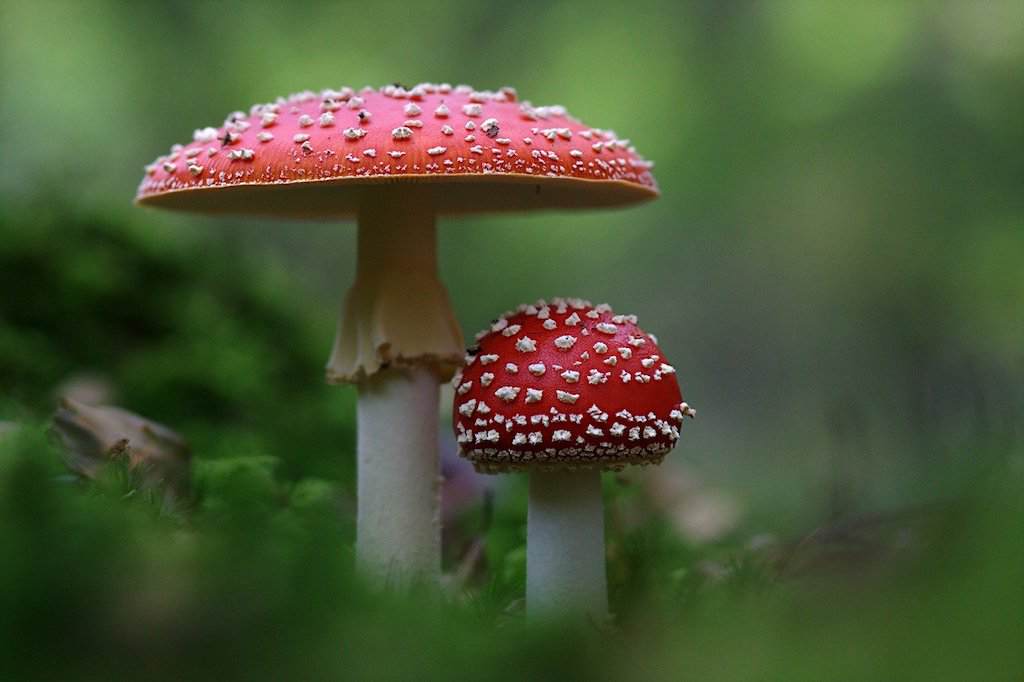

In [8]:
image

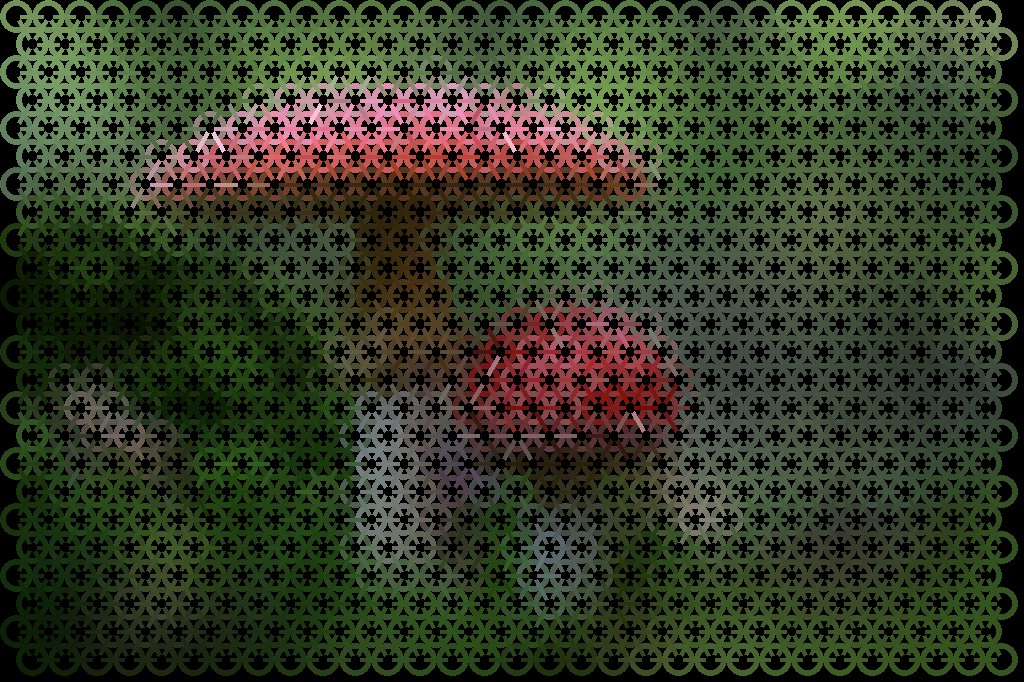

In [9]:
chain_image